# Setup

In [1]:
# Extract and build the benchmark
def make_io_file():
    !make -C io

    !mkdir -p /data/lab1
    !io/io-static -c lab1/iofile

make_io_file()

Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: lab1/iofile
  time: 2.262885875
speed: 7240.31 KBytes/sec


In [5]:
# D Language scripts
D_ffs_read_time = """
syscall::clock_gettime:return
/execname == "io-static" && !self->in_benchmark/
{
    self->in_benchmark = 1;
}

syscall::clock_gettime:entry
/execname == "io-static" && self->in_benchmark/
{
    self->in_benchmark = 0;
}

fbt::ffs_read:entry
/self->in_benchmark/
{
    self->ts = vtimestamp;
}
fbt::ffs_read:return
/self->ts && self->in_benchmark/
{
    @[id] = sum(vtimestamp - self->ts);
    self->ts = 0;
}
"""

D_program_time = """
syscall::execve:return
/execname == "io-static" && self->ts/
{
    trace(vtimestamp - self->ts)
}

syscall::exit:entry
/execname == "io-static"/
{
    self->ts = vtimestamp;
}
"""

D_buf_strategy_freq = """
syscall::clock_gettime:return
/execname == "io-static" && !self->in_benchmark/
{
    self->in_benchmark = 1;
}

syscall::clock_gettime:entry
/execname == "io-static" && self->in_benchmark/
{
    self->in_benchmark = 0;
}

fbt::bufstrategy:entry
/self->in_benchmark/
{
    @num = count()
}
"""

D_cache_flag = """
syscall::clock_gettime:return
/execname == "io-static" && !self->in_benchmark/
{
    self->in_benchmark = 1;
}

syscall::clock_gettime:entry
/execname == "io-static" && self->in_benchmark/
{
    self->in_benchmark = 0;
}

fbt::bufwait:entry
/self->in_benchmark/
{
    @ = quantize(((struct buf*)arg1)->b_iocmd == 0x01 /* BIO_READ */)
}
"""

D_WHOLE_pmap_copy_pages = """
fbt::pmap_copy_pages:entry
{
    @traces[execname] = count()
}
"""

D_WHOLE_bread = """
fbt::bread:entry
/execname == "io-static"/
{
    @traces[id] = count()
}
"""


In [3]:
import itertools

def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def flatten(lst):
    return list(itertools.chain.from_iterable(lst))

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

def label_points(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

def graph(xs, ys, num_trials = 0, save = False, save_name = "plot", title = "", xlabel = ""):
    # np.array expects: [[x1, y1], [x2, y2], ..., [xn, yn]]
    '''df = pd.DataFrame(np.array(np.column_stack((xs, ys))), columns=['x', 'y'])
    plt = df.plot(x='x', y='y',logx=True, grid=True, figsize=(20,10))
    label_points(df.x, df.y, plt)'''
    xvalues = np.reshape(ys, (len(xs), num_trials))[:,:]
    df = pd.DataFrame(xvalues, index=xs)
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]
    plt.figure();
    df.median(1).plot(figsize=(9,9), yerr=error_bars_values, label=title)
    plt.ylabel('I/O bandwidth (KiBytes/sec)')
    plt.xlabel(xlabel)
    plt.xscale('log')
    if save:
        '''fig = plt.get_figure()
        fig.savefig("{}.pdf".format(save_name))'''
        plt.savefig("{}.png".format(save_name))

def benchmark(flags, repeat, exe, filename, buf_sizes, io_sizes, create = False, reset_file = False, dtrace_info = None, bench_name = "" ):
    runs = range(1, repeat + 1)
    outputs = []
    print("\t ==> Running {}".format(exe))
    print("\t\t ==> Reading from {}".format(filename))
    is_dtrace = (dtrace_info != None)
    dtrace_thread = None

    for buffer_size in buf_sizes:
        for io_size in io_sizes:
            cmd = "{} {} -b {} -t {} {}".format(exe, flags, buffer_size, io_size, filename)
            #if "-v" not in flags:
            #    cmd = "time -p " + cmd
            if "-d" in flags:
                discard = !{cmd}

            if create:
                created = !io/io-static -t {str(io_size)} -c lab1/iofile

            if is_dtrace:
                # Create a seperate thread to run the DTrace instrumentation
                dtrace_thread = DTraceConsumerThread(dtrace_info['script'],
                                                        chew_func=None,
                                                        chewrec_func=None,
                                                        walk_func=dtrace_info['agg_fn'],
                                                        sleep=1)
                # Start the DTrace instrumentation
                dtrace_thread.start()

            results = []
            for i in runs:
                out = !{cmd}
                parsed = parse(out)
                results.append(parsed)

            if is_dtrace and dtrace_thread != None:
                # The benchmark has completed - stop the DTrace instrumentation
                dtrace_thread.stop()
                dtrace_thread.join()
                print("\t\t\tdtrace run: {0:2} bytes {1:2} bytes".format(buffer_size, io_size))
            else:
                times = [float(item['time']) for item in results]
                speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see io.c)
                avg_time = sum(times) / len(runs)
                avg_speed = sum(speeds) / len(runs)
                buf_sz = int(results[0]['buffersize'])
                tot_sz = int(results[0]['totalsize'])
                print("\t\t\t{0:2} bytes {1:2} bytes ({2:.2f} KBytes/sec): {3:.6f}s".format(buf_sz, tot_sz, avg_speed, avg_time))
                outputs.append({'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'iosize':tot_sz, 'speeds': speeds, 'times': times})
    if reset_file:
        print("recreating default benchmark file")
        make_io_file()
    return outputs

# Reads

### DTrace

* TODO: measure probe effect

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			512 bytes 16777216 bytes (24317.60 KBytes/sec): 0.808241s
			1024 bytes 16777216 bytes (38839.28 KBytes/sec): 0.493772s
			2048 bytes 16777216 bytes (70938.49 KBytes/sec): 0.301975s
			4096 bytes 16777216 bytes (98632.19 KBytes/sec): 0.219151s
			8192 bytes 16777216 bytes (118238.40 KBytes/sec): 0.178764s
			16384 bytes 16777216 bytes (128340.47 KBytes/sec): 0.162945s
			32768 bytes 16777216 bytes (145843.29 KBytes/sec): 0.137491s
			65536 bytes 16777216 bytes (136976.94 KBytes/sec): 0.158727s
			131072 bytes 16777216 bytes (118415.07 KBytes/sec): 0.184417s
			262144 bytes 16777216 bytes (140619.44 KBytes/sec): 0.129902s
			524288 bytes 16777216 bytes (136097.21 KBytes/sec): 0.151662s
			1048576 bytes 16777216 bytes (124356.88 KBytes/sec): 0.163457s
			2097152 bytes 16777216 bytes (129012.64 KBytes/sec): 0.158585s
			4194304 bytes 16777216 bytes (121022.03 KBytes/sec): 0.167177s
			8388608 bytes 16777216 bytes (122788.96 KBy

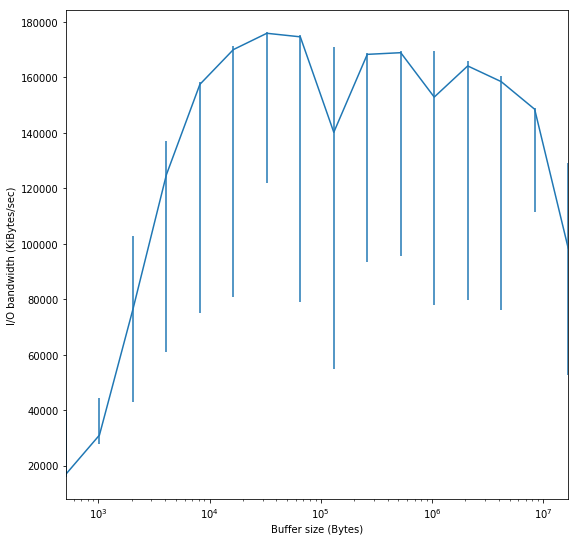

In [37]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(0, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12

results_iofile = benchmark("-v -r -B", RUNS, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = False)
saveas = "static_const_io_flags_vrB_runs_12_oldfile"
graph(BUFFER_SIZES, flatten([item['speeds'] for item in results_iofile]), RUNS, save = True, save_name = saveas)

## Constant IO/Varying Buffer (with cache, static/dynamic)

* Total size: 16MB (default)
* Buffer: varies from 512 to 512 * 2^16
* (io.c modified to output kbytes/sec in same format as other params)
* Run multiple times then average
* Prevent warmup effect

In [ ]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(0, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12
values = []

# Callbacks invoked to process the aggregation
def simple_out(a, b, c, d):
    # print(a,b,c,d)
    values.append(d)

def quantized_out(a, b, c, d):
    print("From DTrace: {} | {} | {} | val: {}".format(a,b,c,d))
    values.append(d)

for io_sz in IO_SIZES:
    for buf_sz in BUFFER_SIZES:
        benchmark("-r -B -q", 1, "io/io-static", "lab1/iofile", [buf_sz], [io_sz], dtrace_info = {'agg_fn':quantized_out, 'script':D_WHOLE_pmap_copy_pages})

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
ERROR! Session/line number was not unique in database. History logging moved to new session 143


## Buffer Size Constant/Vary IO

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			32768 bytes 32768 bytes (6899.23 KBytes/sec): 0.004957s
			32768 bytes 65536 bytes (13431.15 KBytes/sec): 0.005127s
			32768 bytes 131072 bytes (25548.86 KBytes/sec): 0.005335s
			32768 bytes 262144 bytes (42874.84 KBytes/sec): 0.006276s
			32768 bytes 524288 bytes (68508.57 KBytes/sec): 0.007727s
			32768 bytes 1048576 bytes (98489.76 KBytes/sec): 0.010568s
			32768 bytes 2097152 bytes (121815.94 KBytes/sec): 0.017023s
			32768 bytes 4194304 bytes (142069.10 KBytes/sec): 0.029143s
			32768 bytes 8388608 bytes (157767.60 KBytes/sec): 0.051958s
			32768 bytes 16777216 bytes (167877.36 KBytes/sec): 0.097599s
recreating default benchmark file
Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: lab1/iofile
  time: 2.288943750
speed: 7157.89 KBytes/sec
Saved plot at static_const_buf_32k_flags_vrs_runs_12_newfile


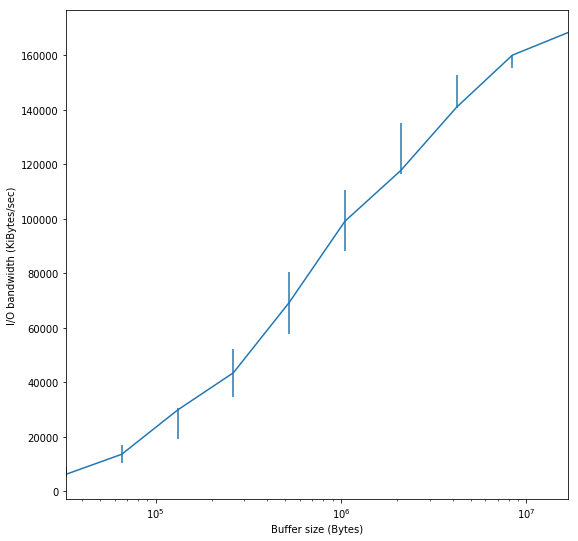

In [50]:
# Setup
IO_START = 512
IO_SIZES = [IO_START * 2 ** exp for exp in range(5, 16)]
BUFFER_SIZES = [512 * 2 ** 5] # Keep constant at default 16KB
RUNS = 12

results_iofile = benchmark("-v -r -s", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = True, reset_file = True)

saveas = "static_const_buf_16k_flags_vrs_runs_12_newfile"
graph(IO_SIZES, flatten([item['speeds'] for item in results_iofile]), RUNS, save = True, save_name = saveas)
print("Saved plot at {}".format(saveas))

# Write

In [ ]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(0, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)
RUNS = 12

# TODO: vwd
results_iofile = benchmark("-v -w -d", RUNS, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = True, reset_file = True)

saveas = "static_const_io_flags_vwd_runs_12_newfile"
graph(BUFFER_SIZES, flatten([item['speeds'] for item in results_iofile]), RUNS, save = True, save_name = saveas, xlabel = 'Buffer size (Bytes)')
print("Saved plot at {}".format(saveas))

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			32768 bytes 32768 bytes (2558.76 KBytes/sec): 0.013470s
			32768 bytes 65536 bytes (4317.07 KBytes/sec): 0.014928s
			32768 bytes 131072 bytes (6166.39 KBytes/sec): 0.020818s
			32768 bytes 262144 bytes (7731.48 KBytes/sec): 0.033224s
			32768 bytes 524288 bytes (8880.72 KBytes/sec): 0.057781s
			32768 bytes 1048576 bytes (9318.05 KBytes/sec): 0.109939s
			32768 bytes 2097152 bytes (9719.14 KBytes/sec): 0.210806s
			32768 bytes 4194304 bytes (7704.44 KBytes/sec): 0.536398s
			32768 bytes 8388608 bytes (7932.14 KBytes/sec): 1.033450s
			32768 bytes 16777216 bytes (9026.35 KBytes/sec): 1.834763s
recreating default benchmark file
Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: lab1/iofile
  time: 1.728589500
speed: 9478.25 KBytes/sec
Saved plot at static_const_buf_32k_flags_vws_runs_12_oldfile


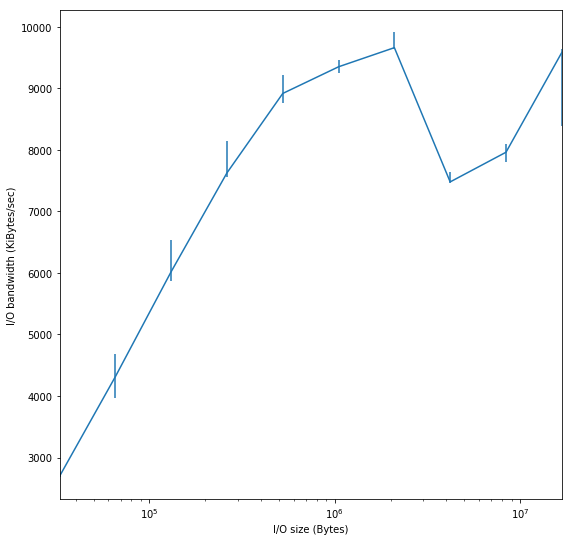

In [13]:
IO_START = 512
IO_SIZES = [IO_START * 2 ** exp for exp in range(6, 16)]
BUFFER_SIZES = [512 * 2 ** 6] # Keep constant at default 16KB
RUNS = 12

# TODO: this configuration
results_iofile = benchmark("-v -w -d", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = False, reset_file = True)

saveas = "static_const_buf_32k_flags_vwd_runs_12_oldfile"
graph(IO_SIZES, flatten([item['speeds'] for item in results_iofile]), RUNS, save = True, title = "Constant 32Kb Buf. Write (Buffer Bypass)", save_name = saveas, xlabel = 'I/O size (Bytes)')
print("Saved plot at {}".format(saveas))

# Notes

Running in the background:
* 701 u0  Is+  0:00.01 /usr/libexec/getty 3wire ttyu0
* 726 U0  Is+  0:00.01 /usr/libexec/getty 3wire.115200 ttyU0
* 724  0  Ss   0:00.18 -csh (csh)
* 732  0  S    1:12.86 /usr/local/bin/python2.7 /usr/local/bin/jupyter-notebook
* 1832  0  R+   0:00.02 ps

FreeBSD SD card driver: https://www.freebsd.org/cgi/man.cgi?mmcsd(4)

SD Card Specification: http://read.pudn.com/downloads188/ebook/881633/SD%203.0/Part_1_Physical_Layer_Specification_Ver3.00_Final_090416.pdf